# REZ mask for Global Wind Atlas

In [40]:
%cd /g/data/w42/dr6273/work/wind_power_comparison/
import functions as fn

/g/data/w42/dr6273/work/wind_power_comparison


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import xarray as xr
import geopandas
import regionmask

In [41]:
gwa_ws = fn.open_gwa_windspeed()

In [42]:
gwa_ws

<xarray.DataArray (lat: 11800, lon: 8080)> Size: 381MB
[95344000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * lon          (lon) float64 65kB 133.5 133.5 133.5 ... 153.7 153.7 153.7
  * lat          (lat) float64 94kB -43.4 -43.4 -43.39 ... -13.91 -13.9 -13.9
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

In [8]:
def create_mask(gpd_df, template_ds, boundary=None, lon_name='lon', lat_name='lat'):
    """
    Create mask from shapefiles and a template xarray dataArray or dataset.
    """
    mask = regionmask.mask_3D_geopandas(
        gpd_df,
        template_ds[lon_name],
        template_ds[lat_name]
    )
    
    if lon_name != 'lon':
        mask = mask.rename({lon_name: 'lon'})
    if lat_name != 'lat':
        mask = mask.rename({lat_name: 'lat'})
        
    if isinstance(boundary, list):
        mask = mask.sel(
            lon=slice(boundary[0], boundary[1]),
            lat=slice(boundary[2], boundary[3])
        )
        
    return mask

In [9]:
# ALready computed shapefile from other project
rez_gpd = geopandas.read_file(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/resource_coded_Indicative_REZ_boundaries_2024_GIS_data.shp"
)

In [10]:
rez_gpd.head()

,Name,Type,code_2023,code_SC205,longitude,latitude,geometry
0,Q1 Far North QLD,REZ,1,1,145.123721,-16.187650,"POLYGON Z ((146.13492 -17.65256 0, 146.09724 -..."
1,Q2 North Qld Clean Energy Hub,REZ,3,3,144.062266,-19.110858,"POLYGON Z ((143.72015 -16.97938 0, 143.87955 -..."
2,Q3 Northern Qld,REZ,2,2,146.333143,-19.197589,"POLYGON Z ((146.27782 -18.7192 0, 146.28263 -1..."
3,Q4 Isaac,REZ,3,3,148.339869,-21.393793,"POLYGON Z ((147.64366 -19.94015 0, 147.68341 -..."
4,Q5 Barcaldine,REZ,2,3,145.595326,-22.855731,"POLYGON Z ((145.82086 -23.84279 0, 145.7004 -2..."


In [11]:
gwa_ws.dims

('lat', 'lon')

In [19]:
# Needs a fair bit of memory (used XL cluster, although looks like it capped out at around 12GB)
rez_mask = create_mask(
    rez_gpd,
    gwa_ws
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/regionmask/core/mask.py:406: UserWarning: Detected overlapping regions. As of v0.11.0 these are correctly taken into account. Note, however, that a different mask is returned than with older versions of regionmask. To suppress this warning, set `overlap=True` (to restore the old, incorrect, behaviour, set `overlap=False`).
  warnings.warn(


In [20]:
rez_codes = rez_gpd["Name"]
rez_codes = [i.split(" ")[0] for i in rez_codes]

In [21]:
rez_mask = rez_mask.assign_coords({
    "region": rez_codes
})

In [22]:
rez_mask

<xarray.DataArray 'mask' (region: 43, lat: 11800, lon: 8080)> Size: 4GB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
    band         int64 8B 1
  * lat          (lat) float64 94kB -43.4 -43.4 -43.39 ... -13.91 -13.9 -13.9
    spatial_ref  int64 8B 0
  * lon          (lon) float64 65kB 133.5 133.5 133.5 ... 153.7 153.7 153.7
  * region       (region) <U3 516B 'Q1' 'Q2' 'Q3' 'Q4' ... 'T1' 'T2' 'T3' 'T4'
Attributes:
    standard_name:  region

In [31]:
rez_mask = rez_mask.drop_vars(["band", "spatial_ref"])

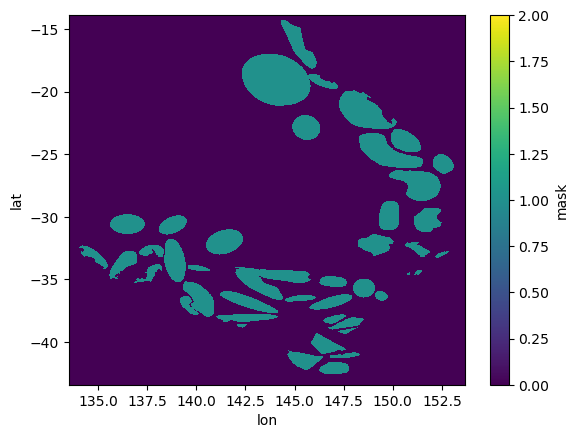

In [32]:
rez_mask.sum("region").plot()

In [35]:
xr.where(rez_mask.sum("region") == 2, 1, 0).sum()

<xarray.DataArray 'mask' ()> Size: 8B
array(221)

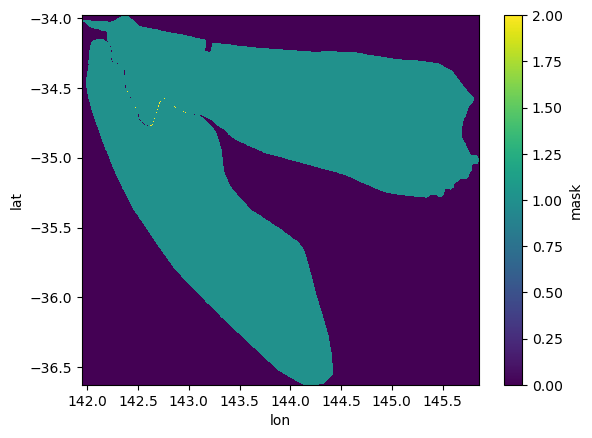

In [33]:
# Note there are 221 grid cells overlapping between REZs, e.g. N5 and V2.
rez_mask.sel(region=["N5", "V2"]).where(rez_mask.sel(region=["N5", "V2"]), drop=True).sum("region").plot()

In [37]:
rez_mask_ds = rez_mask.to_dataset(name='REZ')
rez_mask_ds.to_netcdf('/g/data/w42/dr6273/work/projects/wind_comparison/rez_2024_mask_GWA_grid.nc')